This is an application for reconstructing a model based on what has been explained and mentioned in previous research to verify the accuracy of the results. It also involves comparing with other methods and techniques.
.
> 
A. Bin Durayhim, A. Al-Ajlan, I. Al-Turaiki, and N. Altwaijry, “Towards Accurate Children’s Arabic Handwriting Recognition via Deep Learning,” Applied Sciences 2023, Vol. 13, Page 1692, vol. 13, no. 3, p. 1692, Jan. 2023, doi: 10.3390/APP13031692.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.activations import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,GRU
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score ,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_X.csv",header=None)
y_train = pd.read_csv(r"/kaggle/input/hijja-dataset/train_Y.csv",header=None)

x_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_X.csv",header=None)
y_test = pd.read_csv(r"/kaggle/input/hijja-dataset/test_Y.csv",header=None)

print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (37933, 1024) 
y_train.shape = (37933, 1) 
x_test.shape = (9501, 1024) 
y_test.shape = (9501, 1)


In [3]:
x_train = x_train.iloc[:,:].values
x_test = x_test.iloc[:,:].values
y_train = y_train.iloc[:,:].values
y_test = y_test.iloc[:,:].values
print("x_train.shape =", x_train.shape, "\ny_train.shape =", 
      y_train.shape, "\nx_test.shape =", x_test.shape, "\ny_test.shape =", y_test.shape)

x_train.shape = (37933, 1024) 
y_train.shape = (37933, 1) 
x_test.shape = (9501, 1024) 
y_test.shape = (9501, 1)


In [4]:
x_train = x_train.reshape(-1,32,32,1)
x_test = x_test.reshape(-1,32,32,1)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

(37933, 32, 32, 1) (9501, 32, 32, 1)


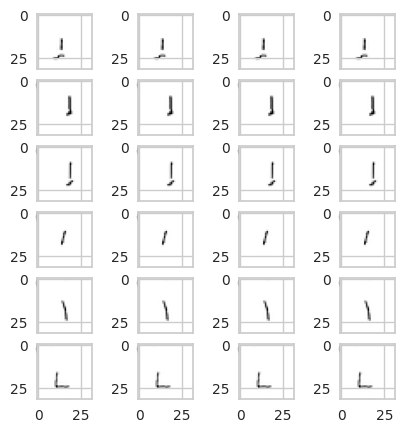

In [5]:
fig, ax = plt.subplots(6,4,figsize=(5,5))

for i in range(6):
    for j in range(4):
        ax[i,j].imshow(x_train[i])

In [6]:
total_classes = len(np.unique(y_train))+1
y_train = to_categorical(y_train,total_classes)
y_test = to_categorical(y_test, total_classes)

print(y_train.shape)
print(y_test.shape)

(37933, 30)
(9501, 30)


In [7]:
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,Conv1D,Flatten, BatchNormalization,SpatialDropout1D, MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding


class attention(layers.Layer):
    def _init_(self,**kwargs):
        super(attention,self)._init_(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [8]:
from tensorflow.keras.layers import InputLayer,BatchNormalization, Reshape,BatchNormalization,ReLU,ZeroPadding2D,DepthwiseConv2D

model = Sequential([
    
     InputLayer(input_shape=(32,32,1)),
    
     Conv2D(64, (3,3), padding='valid', activation='relu',strides=1,
            kernel_initializer='HeNormal'),
     Conv2D(64, (3,3), padding='valid', activation='relu',strides=1),
     MaxPooling2D((2,2), strides=1),
     BatchNormalization(),

     Conv2D(128, (3,3), padding='valid', activation='relu',strides=1),
     MaxPooling2D((2,2), strides=1),
     BatchNormalization(),
    
     Conv2D(128, (3,3), padding='valid', activation='relu',strides=1),
     MaxPooling2D((2,2), strides=1),
     BatchNormalization(),
    
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),

    Dense(30, activation='softmax')
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

In [10]:
history = model.fit(x_train,y_train,
                    #steps_per_epoch=len(x_train)//128,
                    batch_size=128,
                    epochs=150,
                    validation_data=(x_test, y_test),
                   # validation_steps=50
                   )

Epoch 1/150


2023-12-07 13:24:34.322443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


297/297 [==============================] - 17s 36ms/step - loss: 2.8462 - accuracy: 0.3046 - val_loss: 23.0084 - val_accuracy: 0.0460
Epoch 2/150
297/297 [==============================] - 10s 34ms/step - loss: 1.0913 - accuracy: 0.6638 - val_loss: 2.2426 - val_accuracy: 0.4434
Epoch 3/150
297/297 [==============================] - 10s 34ms/step - loss: 0.6701 - accuracy: 0.7932 - val_loss: 0.7128 - val_accuracy: 0.7999
Epoch 4/150
297/297 [==============================] - 10s 34ms/step - loss: 0.4958 - accuracy: 0.8450 - val_loss: 1.1116 - val_accuracy: 0.7094
Epoch 5/150
297/297 [==============================] - 10s 34ms/step - loss: 0.3814 - accuracy: 0.8786 - val_loss: 0.8828 - val_accuracy: 0.7640
Epoch 6/150
297/297 [==============================] - 10s 34ms/step - loss: 0.3215 - accuracy: 0.8956 - val_loss: 0.7471 - val_accuracy: 0.8040
Epoch 7/150
297/297 [==============================] - 10s 34ms/step - loss: 0.2858 - accuracy: 0.9090 - val_loss: 0.8752 - val_accuracy: 0.7

In [11]:
y_held_pred=model.predict(x_test)

297/297 [==============================] - 1s 3ms/step


In [12]:
y_pred=np.argmax(y_held_pred, axis=1)
y_test_1=np.argmax(y_test, axis=1)

print(y_test_1.shape)
print(y_pred.shape)

(9501,)
(9501,)


In [13]:
model.evaluate(x_test,y_test)

297/297 [==============================] - 1s 4ms/step - loss: 29.7652 - accuracy: 0.8626


[29.765186309814453, 0.8626460433006287]

In [14]:
his=model.evaluate(x_test, y_test, verbose=2);
print(his)

297/297 - 1s - loss: 29.7652 - accuracy: 0.8626 - 1s/epoch - 4ms/step
[29.765186309814453, 0.8626460433006287]


In [15]:
y_held_pred_train=model.predict(x_train)

1186/1186 [==============================] - 3s 3ms/step


In [16]:
y_pred_train=np.argmax(y_held_pred_train, axis=1)
y_train_1=np.argmax(y_train, axis=1)

print(y_train_1.shape)
print(y_pred_train.shape)
model.evaluate(x_train, y_train, verbose=2);

(37933,)
(37933,)
1186/1186 - 5s - loss: 1.3513 - accuracy: 0.9947 - 5s/epoch - 4ms/step


<Axes: title={'center': 'Actual vs. Predicted'}, xlabel='Actual G*', ylabel='Predicted G*'>

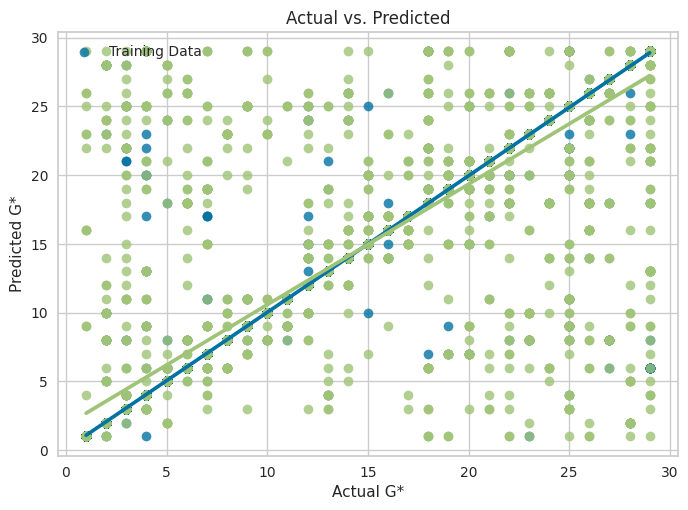

In [17]:
import seaborn as sns

sns.regplot(x=y_train_1,y=y_pred_train, label="Training Data")

plt.xlabel('Actual G*')
plt.ylabel('Predicted G*')
plt.title('Actual vs. Predicted')
plt.legend(loc="upper left")

sns.regplot(x=y_test_1,y=y_pred, label="Testing Data")

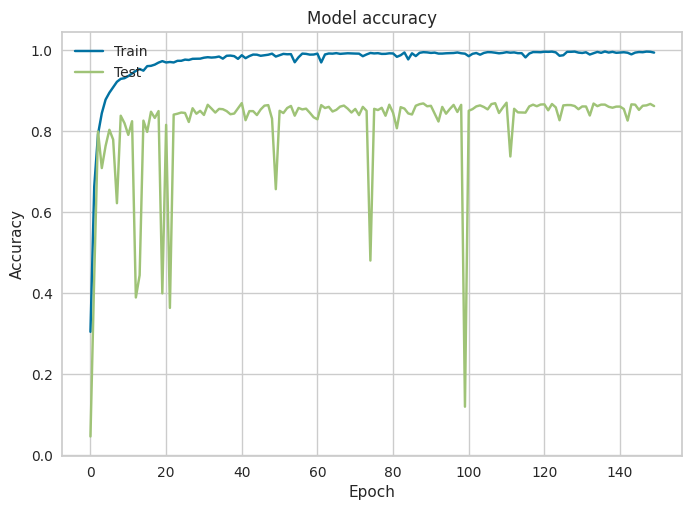

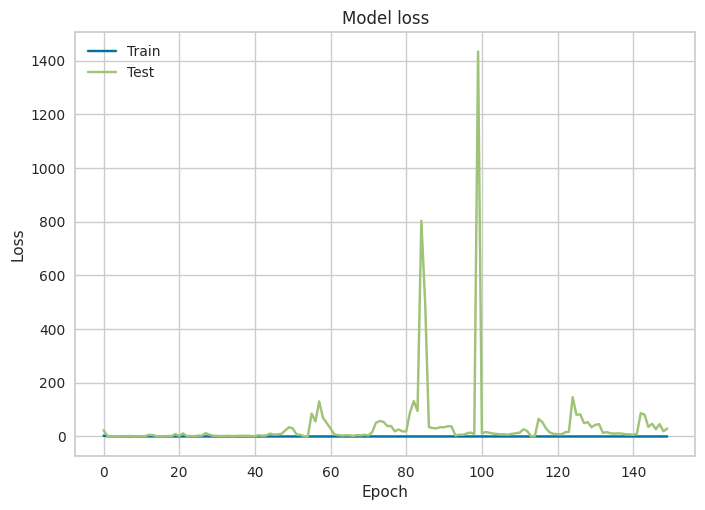

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
y_predicted = model.predict(x_test)
y_grand_truth = y_test
y_predicted = np.argmax(y_predicted,axis=1)
y_grand_truth = np.argmax(y_grand_truth,axis=1)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_grand_truth, y_predicted)

297/297 [==============================] - 1s 3ms/step


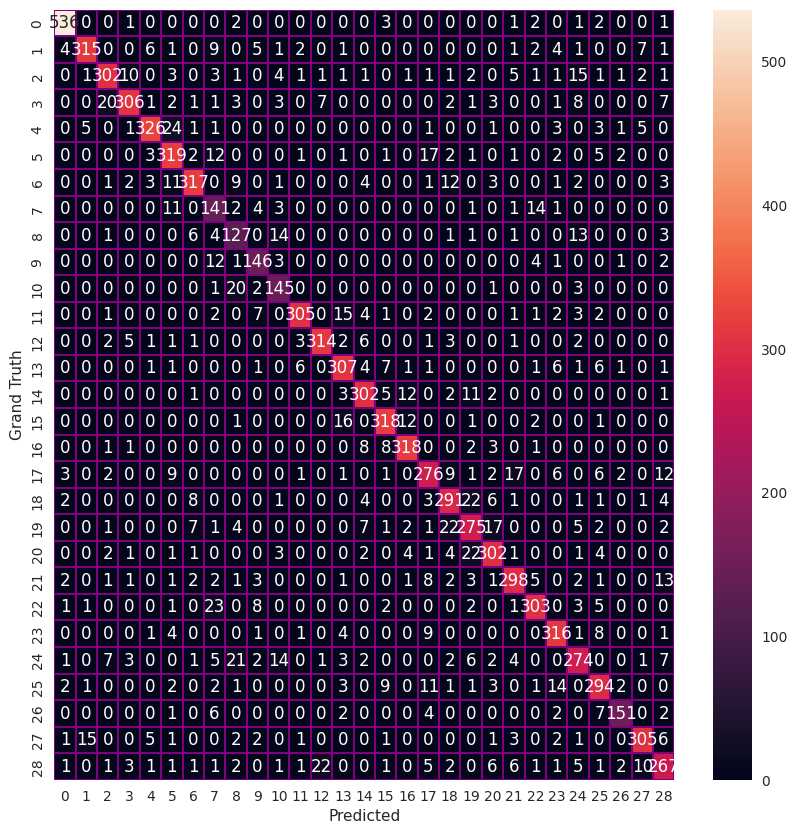

In [20]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,fmt=".0f", annot=True,linewidths=0.1, linecolor="purple", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Grand Truth")
plt.show()

In [21]:
scores = np.zeros((28,3))
def calc_F1(num):
  TP = cm[num,num]
  FN = np.sum(cm[num,:])-cm[num,num]
  FP = np.sum(cm[:,num])-cm[num,num]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*(recall * precision) / (recall + precision)
  return precision, recall, F1_score
for i in range(28):
   precision, recall, F1_score = calc_F1(i)
   scores[i,:] = precision, recall, F1_score
scores_frame = pd.DataFrame(scores,columns=["Precision", "Recall", "F1 Score"], index=[list(range(0, 28))])

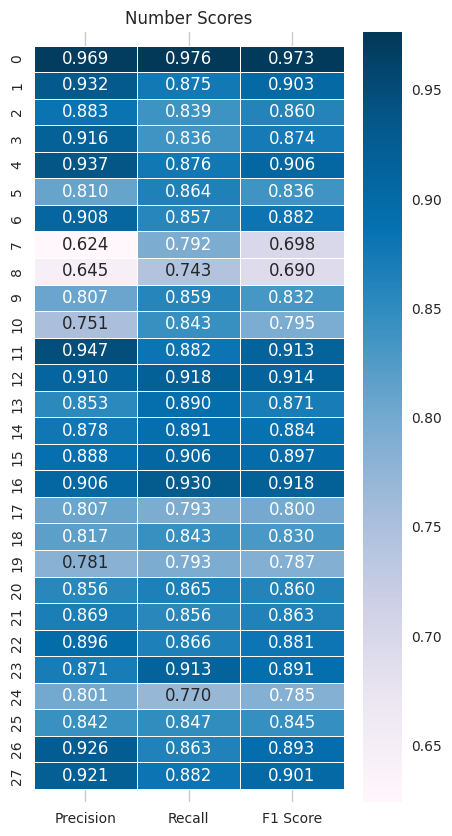

In [22]:
f, ax = plt.subplots(figsize = (5,10))
ax.set_title('Number Scores')
sns.heatmap(scores_frame, annot=True, fmt=".3f", linewidths=0.5, cmap="PuBu", cbar=True, ax=ax)
bottom, top = ax.get_ylim()
plt.ylabel("")
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [23]:
# Functions: Performance Evaluation 

def Performance(Model , y_predd): 
    
    # model accuracy
    accuracy = accuracy_score(y_test_1, y_predd)
    print( Model +' Accuracy:'+'\033[1m {:.2f}%'.format(accuracy*100))
    
    # model Classification Report
    print('\nClassification Report: '+'\033[0m')
    print('*' * 22)
    print(classification_report(y_test_1, y_predd))

In [24]:
Performance('LSTM' , y_pred)

LSTM Accuracy: 86.26%

Classification Report: 
**********************
              precision    recall  f1-score   support

           1       0.97      0.98      0.97       549
           2       0.93      0.88      0.90       360
           3       0.88      0.84      0.86       360
           4       0.92      0.84      0.87       366
           5       0.94      0.88      0.91       372
           6       0.81      0.86      0.84       369
           7       0.91      0.86      0.88       370
           8       0.62      0.79      0.70       178
           9       0.64      0.74      0.69       171
          10       0.81      0.86      0.83       170
          11       0.75      0.84      0.79       172
          12       0.95      0.88      0.91       346
          13       0.91      0.92      0.91       342
          14       0.85      0.89      0.87       345
          15       0.88      0.89      0.88       339
          16       0.89      0.91      0.90       351
          1